## Loading Packages

In [1]:
import pandas as pd
import nltk as nltk

from google.cloud import storage
import io

In [2]:
import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [4]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Loading Data

In [5]:
path = 'gs://msca-bdp-tweets/final_project'
data = spark.read.json(path)

In [7]:
data.show(5)

+------------+-----------+--------------------+------------------+--------------------+-----------------+--------------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+--------------------+-------------------+--------------------+-----------------------+-----------+-------------+---------+--------------------+--------------------+--------------------+-------------+---------+--------------------+---------------------+
|contributors|coordinates|          created_at|display_text_range|            entities|extended_entities|      extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sen

In [6]:
data.count()

25191000

In [8]:
data.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: bo

In [6]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [13]:
pd_view.head(n=3)

contributors coordinates                      created_at display_text_range  \
0         None        None  Sat Oct 30 02:52:21 +0000 2021               None   
1         None        None  Sat Oct 30 02:52:21 +0000 2021               None   
2         None        None  Sat Oct 30 02:52:21 +0000 2021           [17, 77]   

                                                                                                                                         entities  \
0                                                     ([], None, [], [], [(754006735468261376, 754006735468261376, [3, 11], MONTERO 🦋, LilNasX)])   
1  ([], None, [], [(twitter.com/i/web/status/1…, https://twitter.com/i/web/status/1454279982096789505, [117, 140], https://t.co/AQa9LVqVm9)], [])   
2                                              ([], None, [], [], [(266929217, 266929217, [0, 16], Roaring Mice but Spoooooky, GarrAarghHrumph)])   

  extended_entities  \
0              None   
1              None   
2              None   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             extended_tweet  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      None   
1  ([0, 238], ([Row(indices=[168, 175], text='church'), Row(indices=[176, 192], text='taxexemptstatus'), Row(indices=[193, 213], text='politicalactivities')], None, [], [Row(display_url='businessinsider.com/doug-mastriano…', expanded_url='https://www.businessinsider.com/doug-mastriano-suggests-covid-19-vaccines-are-not-true-vaccines-2021-10?utm_source=taboola', indices=[215, 238], url='https://t.co/ye7jjVAFaB')], []), None, “At a political fundraiser hosted by the tax-exempt, evangelical Time Ministries Church in central Pennsylvania…” Nothing wrong w THAT statement at all. Of course not. #church #taxexemptstatus #politicalactivities  https://t.co/ye7jjVAFaB)   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      None   

   favorite_count  favorited filter_level  ... reply_count  retweet_count  \
0               0      False          low  ...           0              0   
1               0      False          low  ...           0              0   
2               0      False          low  ...           0             

## Discard Irrelevant Rows

In [7]:
df_text_covid = data.filter(lower(data.text).contains("covid"))

In [8]:
df_text_covid.show(5)

+------------+-----------+--------------------+------------------+--------------------+-----------------+--------------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+--------------------+-------------------+--------------------+-----------------------+-----------+-------------+---------+--------------------+--------------------+--------------------+-------------+---------+--------------------+---------------------+
|contributors|coordinates|          created_at|display_text_range|            entities|extended_entities|      extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sen

In [19]:
df_text_covid.count()

14973841

Now we have only COVID related tweets in new dataframe.

In [21]:
pd_view = df_text_covid.limit(1000).toPandas()

In [22]:
pd_view.head(n=3)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,...,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,withheld_in_countries
0,None,None,Sat Oct 30 02:52:21 +0000 2021,"[17, 77]","([], None, [], [], [(266929217, 266929217, [0, 16], Roaring Mice but Spoooooky, GarrAarghHrumph)])",None,None,0,False,low,...,0,0,False,None,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@GarrAarghHrumph I got my Covid booster today too, and then ate pesto fries 😂",1635562341946,False,"(False, Mon May 21 04:31:56 +0000 2012, True, False, Mostly skating banter and sarcasm....plentiful sarcasm., 1103, None, 70, None, 172, False, 586248544, 586248544, False, None, 4, Michigan, USA, Emily Joy, None, C0DEED, http://abs.twimg.com/images/themes/theme1/bg.png, https://abs.twimg.com/images/themes/theme1/bg.png, False, https://pbs.twimg.com/profile_banners/586248544/1484372798, http://pbs.twimg.com/profile_images/820145069059698696/bHEaLS3w_normal.jpg, https://pbs.twimg.com/profile_images/820145069059698696/bHEaLS3w_normal.jpg, 1DA1F2, C0DEED, DDEEF6, 333333, True, False, JoyofEmily, 2389, None, none, None, None, False, [])",None
1,None,None,Sat Oct 30 02:52:22 +0000 2021,None,"([], None, [], [], [(1318094385431662593, 1318094385431662593, [3, 19], Denise 🦕, Denise_Old_Lady)])",None,None,0,False,low,...,0,0,False,"(None, None, Sat Oct 30 02:49:15 +0000 2021, None, ([], None, [], [], []), None, None, 0, False, low, None, 1454279200320405505, 1454279200320405505, None, None, None, None, None, True, en, None, None, 0, (None, None, Fri Oct 29 21:01:22 +0000 2021, [17, 140], ([], None, [], [Row(display_url='twitter.com/i/web/status/1…', expanded_url='https://twitter.com/i/web/status/1454191652545843201', indices=[117, 140], url='https://t.co/d0WyAA6jhx')], [Row(id=762389795037294592, id_str='762389795037294592', indices=[0, 16], name='Melissa Tate', screen_name='TheRightMelissa')]), None, ([17, 159], Row(hashtags=[], media=None, symbols=[], urls=[], user_mentions=[Row(id=762389795037294592, id_str='762389795037294592', indices=[0, 16], name='Melissa Tate', screen_name='TheRightMelissa')]), None, @TheRightMelissa He doesn't have the right to infect others with covid. If he stays home 24/7 I am ok with this decision, otherwise he needs to get vaccinated.), 17, False, low, None, 1454191652545843201, 1454191652545843201, TheRightMelissa, 1454173330995560452, 1454173330995560452, 762389795037294592, 762389795037294592, False, en, None, None, 5, None, None, 97, 0, False, None, <a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>, @TheRightMelissa He doesn't have the right to infect others with covid. If he stays home 24/7 I am ok with this dec… https://t.co/d0WyAA6jhx, True, (False, Mon Dec 14 02:24:30 +0000 2009, False, False, Average human and coder, obj-c enthusiast. CEO of myself, inc. - checkout http://ipban.com | http://digitalruby.com | https://www.linkedin.com/in/jjxtra/, 972, None, 291, None, 27, False, 96674788, 96674788, False, None, 8, Salt Lake City, Utah, USA, Jeff Johnson, None, FFFFFF, http://abs.twimg.com/images/themes/theme9/bg.gif, https://abs.twimg.com/images/themes/theme9/bg.gif, True, https://pbs.twimg.com/profile_banners/96674788/1599672180, http://pbs.twimg.com/profile_images/1261494410987974656/JnirceDl_normal.jpg, https://pbs.twimg.com/profile_images/1261494410987974656/JnirceDl_normal.jpg, 2FC2EF, 000000, 252429, 666666, True, False, jjxtra, 1182, None, none, http://www.digitalruby.com, None, False, []), None, None), 1454191652545843201, 1454191652545843201, (twitter.com/jjxtra/status/…, https://twitter.com/jjxtra/status/1454191652545843201, https://t.co/1nPY5cuBFx), 0, 1, False, None, <a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>, Duh, don't you know that vaccinated people can still get &amp; spread covid?, 

## EDA

In [ ]:
df_text_covid.describe()

summary,contributors,created_at,favorite_count,filter_level,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,lang,quote_count,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,source,text,timestamp_ms
count,0,14973841,14973841,14973841,14973841,14973841,1907987,1843873,1843873,1907987,1907987,14973841,14973841,1251878,1251878,14973841,14973841,14973841,14973841,14973841
mean,null,null,0.0,null,1.453828677557415...,1.453828677557415...,Infinity,1.453069542240005...,1.453069542240005...,4.393414073436544...,4.393414073436544...,null,0.0,1.450464480089800...,1.450464480089800...,0.0,0.0,null,null,1.635454742217016...
stddev,null,null,0.0,null,2.963188286377231E15,2.963188286377231E15,NaN,1.468956448959299...,1.468956448959299...,5.829131551857952E17,5.829131551857952E17,null,0.0,2.755848711217400...,2.755848711217400...,0.0,0.0,null,null,7.064791408485224E8
min,null,Fri Nov 05 00:00:...,0,low,1448850337247367173,1448850337247367173,000000001404072,15754281,1001725136045793280,12,1000002715999784961,en,0,1403739068,1000324596757942272,0,0,"<a href=""HTTP://b...",! An extremely s...,1634267813394
max,null,Wed Oct 27 23:59:...,0,low,1459021442469666820,1459021442469666820,zzzzzz_cz17,1459021288719200304,998963717004935169,1458982120475398146,999991396445585410,en,0,1459020209969238020,999652465548054533,0,0,"<a href=""https://...",🫖After a long CO...,1636692793849


Given "contributors" is an empty column, and "quote_count", "reply_count", "retweet_count" are all 0's, we drop the columns from our dataframe. 

We also count the null values in each column to filter out variables that are poorly populated. 

In [ ]:
df_filter_var = df_text_covid.agg(*[count(when(isnull(c), c)).alias(c) for c in df_text_covid.columns])


In [ ]:
df_filter_var.show()

+------------+-----------+----------+------------------+--------+-----------------+--------------+--------------+---------+------------+--------+---+------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+--------+------------------+-----------+-------------+----------------+--------------------+-----------------------+-----------+-------------+---------+----------------+------+----+------------+---------+----+---------------------+
|contributors|coordinates|created_at|display_text_range|entities|extended_entities|extended_tweet|favorite_count|favorited|filter_level|     geo| id|id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|   place|possibly_sensitive|quote_count|quoted_status|quoted_status_id|quoted_status_id_str|quoted_status_permalink|reply_count|retweet_count|retweeted|retweeted_status|source|text|t

In [ ]:
pd_view = df_filter_var.limit(100000).toPandas()

In [ ]:
pd_view.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,...,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,withheld_in_countries
0,14973841,14972160,0,12761230,0,14298467,12865521,0,0,0,...,0,0,0,4331054,0,0,0,0,0,14972161


We then drop the columns that are poorly populated, i.e. are mainly null values, and the variables that consists of only 0. 

In [8]:
df_cleaned = df_text_covid.drop("contributors", "coordinates", "withheld_in_countries", "quote_count", "reply_count", "retweet_count")


In [9]:
df_cleaned.show(5)

+--------------------+------------------+--------------------+-----------------+--------------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+--------------------+-------------------+--------------------+-----------------------+---------+--------------------+--------------------+--------------------+-------------+---------+--------------------+
|          created_at|display_text_range|            entities|extended_entities|      extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sensitive|       quoted_status|   quoted_status_id|quoted_status_id_str|quoted_status_permalink|retweeted|    ret

In [13]:
df_cleaned.count()

14973841

## Sorting Users by Organization

### Select the columns used

In [9]:
df_text = df_cleaned.select('user.id', 'user.description', 'user.name', 'user.screen_name', 'text')

In [10]:
df_text.show(5)

+-------------------+--------------------+--------------------+---------------+--------------------+
|                 id|         description|                name|    screen_name|                text|
+-------------------+--------------------+--------------------+---------------+--------------------+
|          586248544|Mostly skating ba...|           Emily Joy|     JoyofEmily|@GarrAarghHrumph ...|
|1109641163890319360| Soldier of the Lion|       Judith Becker|JudithB61667227|RT @Denise_Old_La...|
|          214105439|Often tweets abou...|TheRealFourSeason...|         Toky02|@pahpcorn @Lisa_T...|
|          954159751|Futures trader. I...|       Aaron Bradley|   Godblsmnymkr|@polan13 @mark_do...|
|         4879591625|                null|    Bright Starlight|      AHBSLight|RT @LegendaryEner...|
+-------------------+--------------------+--------------------+---------------+--------------------+
only showing top 5 rows



In [11]:
df_id_text = df_text.select('id', 'text')


In [37]:
df_id_text.count()

14973841

#### Sort Users By Organization

In [12]:
df_user_profile = df_text.select('id', 'description')

In [13]:
org_gov = ['gov', 'congress', 'representative', 'presiden']
org_health = ['health', 'hospital']
org_news = ['news', 'press', 'post', 'journal']
org_social_media = ['youtuber', 'streamer', 'tik tok', 'influencer']
org_celebrity = ['singer', 'musician', 'actor', 'actress', 'movie', 'producer', 'rapper']

In [14]:
org_dict = {'government': org_gov, 
            'health': org_health,
            'news' : org_news,
            'social_media' : org_social_media,
            'celebrity' : org_celebrity
           }

In [15]:
df_user_profile = df_user_profile.\
withColumn("organization",lit("other"))

In [27]:
df_user_profile.show(5)

+-------------------+--------------------+------------+
|                 id|         description|organization|
+-------------------+--------------------+------------+
|          586248544|Mostly skating ba...|       other|
|1109641163890319360| Soldier of the Lion|       other|
|          214105439|Often tweets abou...|       other|
|          954159751|Futures trader. I...|       other|
|         4879591625|                null|       other|
+-------------------+--------------------+------------+
only showing top 5 rows



In [16]:
for key, value in org_dict.items():
    for k in value:
        df_user_profile = df_user_profile.\
        withColumn("organization", when(lower(df_user_profile.description).contains(k), key).\
                   otherwise(df_user_profile.organization))


In [17]:
df_user_profile.show(5)


+-------------------+--------------------+------------+
|                 id|         description|organization|
+-------------------+--------------------+------------+
|          586248544|Mostly skating ba...|       other|
|1109641163890319360| Soldier of the Lion|       other|
|          214105439|Often tweets abou...|        news|
|          954159751|Futures trader. I...|       other|
|         4879591625|                null|       other|
+-------------------+--------------------+------------+
only showing top 5 rows



In [38]:
df_user_profile.count()

14973841

In [18]:
df_user_org = df_user_profile.drop('description')

In [19]:
df_user_org_dict = df_user_org.dropDuplicates()

In [20]:
df_user_org_dict.show(5)

+-------------------+------------+
|                 id|organization|
+-------------------+------------+
| 707996021268291584|       other|
|         2353441776|       other|
|         3331885857|       other|
|1418545840730251264|       other|
|           64683582|       other|
+-------------------+------------+
only showing top 5 rows



In [21]:
df_user_org_check = df_user_org_dict.groupBy('id', 'organization').agg(count('*').alias('count')).orderBy('count', ascending = False)

In [22]:
df_user_org_check.show(5)

+-------------------+------------+-----+
|                 id|organization|count|
+-------------------+------------+-----+
|1358819872545857546|       other|    1|
|1330195717718233096|       other|    1|
|           14466441|       other|    1|
|          348686421|       other|    1|
|1302628820252536834|       other|    1|
+-------------------+------------+-----+
only showing top 5 rows



In [23]:
df_user_org_check.count()

3213418

In [51]:
df_user_org.show(5)

+-------------------+------------+
|                 id|organization|
+-------------------+------------+
|          586248544|       other|
|1109641163890319360|       other|
|          214105439|        news|
|          954159751|       other|
|         4879591625|       other|
+-------------------+------------+
only showing top 5 rows



In [21]:
df_user_text = df_id_text.join(df_user_org, 'id', how = 'inner')

In [22]:
df_user_text.show(5)

+-----+--------------------+------------+
|   id|                text|organization|
+-----+--------------------+------------+
|  964|My kids finally g...|       other|
|  964|My kids finally g...|       other|
|  964|(I know it will b...|       other|
|  964|(I know it will b...|       other|
|38543|I’m really not su...|       other|
+-----+--------------------+------------+
only showing top 5 rows



In [29]:
df_user_text = df_user_text.dropDuplicates()

In [ ]:
df_user_text.show(5)

+-----+--------------------+------------+
|   id|                text|organization|
+-----+--------------------+------------+
|  964|My kids finally g...|       other|
|  964|(I know it will b...|       other|
|38543|I’m really not su...|       other|
|48763|RT @ChuckCallesto...|       other|
|60033|“Covid measures a...|       other|
+-----+--------------------+------------+
only showing top 5 rows



In [23]:
df_org_social_media = df_user_text.filter("organization == 'social_media'")

In [24]:
df_government = df_user_text.filter("organization == 'government'")

In [25]:
df_celebrity = df_user_text.filter("organization == 'celebrity'")

In [26]:
df_health = df_user_text.filter("organization == 'health'")

In [27]:
df_news = df_user_text.filter("organization == 'news'")

In [28]:
df_other = df_user_text.filter("organization == 'other'")

In [ ]:
df_org_social_media.show(5)

+--------+--------------------+------------+
|      id|                text|organization|
+--------+--------------------+------------+
|10666172|RT @DrEricDing: ⚠...|social_media|
|10666172|RT @Nature: A Nat...|social_media|
|10666172|RT @DrEricDing: ⚠...|social_media|
|10666172|RT @TomAvril1: Wh...|social_media|
|10666172|@KarinaVoggel @Ma...|social_media|
+--------+--------------------+------------+
only showing top 5 rows



### Government

In [29]:
df_gov = df_government.select('text')

In [55]:
df_gov.count()

372383

In [49]:
df_government_text = df_gov.sample(fraction=0.01, seed=3).limit(3000)

In [50]:
text = df_government_text.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [51]:
row = Row('text')
df_gov_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_gov_text.limit(5)

text,id
[Matching tweets ...,0
[Why is Alabama u...,1
[RT @kylegriffin1...,2
[Nova Scotia is a...,3
[Nova Scotia is a...,4


In [52]:
df_gov_text.count()

3000

In [53]:
#Break up text into tokens
df_gov_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_gov_tokens = df_gov_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_gov_tokens.limit(5).toPandas()

,list_of_words,id
0,"[@twooldridge, fyi,, flew, this, week, for, the, first, time, since, covid, (weekly, flights, before, covid), and, it, was, suprisin…, https://t.co/wc23jnxcyx]",0
1,"[rt, @hilarybennmp:, wasn’t, able, to, vote, today, because, am, isolating, having, tested, positive, for, covid.]",1
2,"[rt, @hilarybennmp:, wasn’t, able, to, vote, today, because, am, isolating, having, tested, positive, for, covid.]",2
3,"[rt, @hilarybennmp:, wasn’t, able, to, vote, today, because, am, isolating, having, tested, positive, for, covid.]",3
4,"[rt, @hilarybennmp:, wasn’t, able, to, vote, today, because, am, isolating, having, tested, positive, for, covid.]",4


In [54]:
df_gov_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [55]:
df_gov_tokens.count()

3000

In [56]:
gov_vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_gov_vectorize = gov_vectorize.fit(df_gov_tokens).transform(df_gov_tokens)

In [57]:
df_gov_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[rt, @benwakana46:, ""president, joe, biden, is, right, to, stand, by, his, vaccine, requirements.""\n\n""the, covid-19, mandates, imposed, so, far, by, companies, a…]",0,"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[rt, @nydailynews:, howard, stern, sacks, aaron, rodgers, over, covid\n\nrodgers, suggested, he’d, been, “immunized,”, but, that, was, through, diy, homeopathi…]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[rt, @northernsprw:, holy, smokes., covid, has, now, killed, more, americans, than, hiv/aids, *ever*, has, \n\nhttps://t.co/lwu92t7oso, via, @thenationalnews]",2,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, @atrupar:, fox, news, anchor, neil, cavuto's, covid, diagnosis, has, ironically, gotten, more, coverage, on, msnbc, than, on, fox, news, or, fox, business,, w…]",3,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, @thekitchenista:, it’s, also, not, fair, to, first, responders, and, hospitals, already, exhausted, from, covid, to, have, mass, casualty, event, that, li…]",4,"(1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [58]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_gov_vectorize)
df_gov_hashed = mh.fit(df_gov_vectorize).transform(df_gov_vectorize)

In [88]:
df_hashed_text = df_gov_text.join(df_gov_hashed, "id", how = 'left')
df_hashed_text.limit(5)

KeyboardInterrupt: 

In [ ]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [89]:
df_dups_30 = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,1750,1754,"(@lavern_spicer SMH comparing COVID-19 to @MagicJohnson having HIV you need Jesus for real, not the #QAnonCult count… https://t.co/R2thqYgGwM,)","(@MTRichards400 trending topics exposes how dumb people really are about COVID-19.,)"
1,0.0,1748,1750,"(RT @ananavarro: Aaron Rodgers lied, violated NFL COVID protocols and endangered other people.\n\nRodgers was fined $14,650. That is 0.0001093…,)","(@lavern_spicer SMH comparing COVID-19 to @MagicJohnson having HIV you need Jesus for real, not the #QAnonCult count… https://t.co/R2thqYgGwM,)"
2,0.0,1943,1944,"(RT @Melanin_Mmaps: I just love how COVID has decided to behave because of elections.,)","(@BostonSportsDa2 Not to mention, Tatum had his struggles with long haul Covid, but take away that 15 game stretch o… https://t.co/HSSjHU9wrg,)"
3,0.0,2926,2927,"(@l_monyelle @germain_ad https://t.co/rN9Wae4oNZ\n\n*IMMIGRATION RECRUITMENT|| COVID-19 PROTOCOLS BROKEN🤔*,)","(@GNev2 https://t.co/rN9Wae4oNZ\n\n*IMMIGRATION RECRUITMENT|| COVID-19 PROTOCOLS BROKEN🤔*,)"
4,0.0,2190,2194,"(RT @JonLemire: SAN JOSE, Calif. (AP) — The NHL has suspended San Jose Sharks forward Evander Kane for 21 games for submitting a fake COVID-…,)","(RT @Troydan: covid has been putting up Wilt Chamberlain numbers today in the sports world,)"


In [90]:
records = df_hashed_text.count()
dups = df_dups_30.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  2348
Unique titles based on { 0.3 } jaccard distance:  0.3 :  652


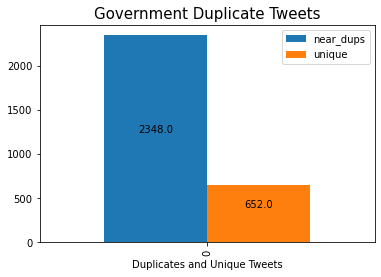

In [91]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates and Unique Tweets")
ax.set_title('Government Duplicate Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [64]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [66]:
df_dups_50 = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.307692,346,452,"(@nypost Duuuudes. It doesn’t matter. \n\nCDC- vaccinated; it is EXPECTED to get covid infection, it CAN be transmissi… https://t.co/waaiXUKiuG,)","(@midori_oshii @porterguy1 CDC- vaccinated; it is EXPECTED to get covid infection, it CAN be transmissible, it MAY h… https://t.co/y8luB1DQR3,)"
1,0.285714,445,453,"(@BubblegumRevolt CDC Vaccinated; it is EXPECTED to get covid infection, it CAN be transmissible, it MAY help to red… https://t.co/lyeO8YjLdZ,)","(@midori_oshii @porterguy1 CDC- vaccinated; it is EXPECTED to get covid infection, it CAN be transmissible, it MAY h… https://t.co/y8luB1DQR3,)"
2,0.000000,394,448,"(@JHGood @MSNBC @MSNBCDaily 🤫🤫🤫🍦🍦🍦🙊🙊\n\nCDC- vaccinated; it is EXPECTED to get covid infection, it CAN be transmissibl… https://t.co/cdSIBQrNwS,)","(@ZooMunch @blackintheempir CDC- vaccinated; it is EXPECTED to get covid infection, it CAN be transmissible, it MAY… https://t.co/XoydyiTuBx,)"
3,0.000000,2994,2999,"(RT @krishgm: No Plan B yet, says @sajidjavid, claiming covid deaths are “mercifully low”. There were 179 deaths listed today and 954 in the…,)","(RT @krishgm: No Plan B yet, says @sajidjavid, claiming covid deaths are “mercifully low”. There were 179 deaths listed today and 954 in the…,)"
4,0.000000,2415,2416,"(RT @NHSActivistRN: Have you had a Covid booster?\n\nFeel free to elaborate in comments\n\n#COVID19,)","(RT @NHSActivistRN: Have you had a Covid booster?\n\nFeel free to elaborate in comments\n\n#COVID19,)"


In [67]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3000
Duplicate titles based on { 0.5 } jaccard distance:  1612
Unique titles based on { 0.5 } jaccard distance:  0.5 :  1388


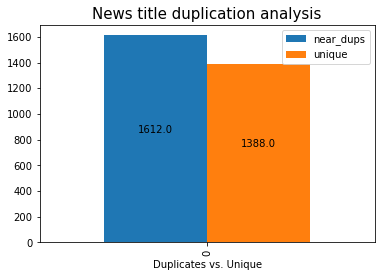

In [68]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

##### High Jaccard Distance

In [69]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [70]:
df_dups_70 = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000000,643,644,"(@ashishkjha Vaccinated people still get sick, still spread the virus and are still dying of COVID-19 disease. https://t.co/w4008v7p6a,)","(RT @TrumpOrLump: Hey what’s the difference between Covid and cold/flu/allergies/stomach viruses??,)"
1,0.454545,1367,2115,"(India's new COVID-19 guidelines for foreigners👇\n@diprjk @infjammu https://t.co/aTeBXr4GHs,)","(RT @Liz_Wheeler: When politicians mandate the covid vaxx for kids 5-11, the wave of backlash from parents is gonna make Virginia look like…,)"
2,0.000000,1685,1689,"(RT @RobbieProuse: Amazing how quickly the covid experts Vallance and Van Tam have switched their attentions to Climate change. In the click…,)","(RT @SteveKrak: Well it’s official, Florida currently has the LOWEST per capita COVID cases among the contiguous 48 states.\n\nLooking forward…,)"
3,0.000000,1685,2845,"(RT @RobbieProuse: Amazing how quickly the covid experts Vallance and Van Tam have switched their attentions to Climate change. In the click…,)","(@Quicktake 🇺🇸 @WHCOVIDResponse\n🇺🇸 @CDCgov\n🇺🇸 @NIH\n🇺🇸 @US_FDA\n🇺🇸 @HHSGov\n\n➡️ Help Protect:\n\n🇺🇸 #PublicHealth\n🇺🇸… https://t.co/KNHyjHGRlj,)"
4,0.454545,2086,2845,"(RT @MsAvaArmstrong: Democrats used covid as a smoke screen\nto steal an election~,)","(@Quicktake 🇺🇸 @WHCOVIDResponse\n🇺🇸 @CDCgov\n🇺🇸 @NIH\n🇺🇸 @US_FDA\n🇺🇸 @HHSGov\n\n➡️ Help Protect:\n\n🇺🇸 #PublicHealth\n🇺🇸… https://t.co/KNHyjHGRlj,)"


In [71]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3000
Duplicate titles based on { 0.7 } jaccard distance:  1836
Unique titles based on { 0.7 } jaccard distance:  0.7 :  1164


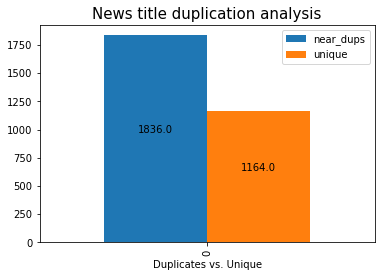

In [72]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Social Media

In [74]:
df_social = df_org_social_media.select('text').sample(fraction=0.01, seed=3).limit(3000)

In [75]:
text = df_social.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [76]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
[RT @FieldYates: ...,0
[RT @MMAFighting:...,1
[RT @TomPelissero...,2
[RT @AdamSchefter...,3
[RT @RapSheet: #P...,4


In [77]:
#Break up text into tokens
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[rt, @janemorgannz1:, oh, my, god, so, cool!, friend, of, mine, (a, once, firm, believer, in, the, way, ardern, has, handled, covid), has, finally, woken, up., \n\nh…]",0
1,"[rt, @taggliatelle:, who, are, the, covid, positive, escapees?]",1
2,"[rt, @williamson_nz:, dr, bloomfield, just, said, 84, covid, positive, cases, from, 55, households, are, being, allowed, to, self, isolate, at, home., really?\nye…]",2
3,"[rt, @elliotikilei:, @newshubnz, is, covid, combustible, now?, with, taxpayer-funded, 'experts', rolling, out, doomsday, material, that, are, never, accurate…]",3
4,"[@charleton_hone, add, that, one, to, the, covid, death, tally.]",4


In [78]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = gov_vectorize.fit(df_tokens).transform(df_tokens)

In [79]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[the, cdc, have, said., that, people, who, have, already, caught, covid, have, higher, chance, of, catching, it, again,, in, comparis…, https://t.co/rv5wawwmwq]",0,"(0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[rt, @itslinzzzz:, don’t, have, anymore, 1,, 5,, 10, year, plans., grief, and, covid, ruined, that., i’m, just, here, until, i’m, not.]",1,"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[rt, @reuters:, britain, became, the, first, country, to, approve, the, covid-19, antiviral, pill, jointly, developed, by, merck, and, ridgeback, biotherapeuti…]",2,"(1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, @fortunemagazine:, new, u.s., covid, cases, are, down, 22%., see, how, your, state, is, doing, https://t.co/bhdxo3kmgd]",3,"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, @fortunemagazine:, fda, approves, moderna, and, johnson, &amp;, johnson, boosters,, as, well, as, mixing, covid, vaccines, https://t.co/tkw1mp9cuu]",4,"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [80]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [81]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
65,[RT @WHCOS: Monda...,"[rt, @amar4odisha...","(9877,[0,2,5,9,12...","[[4.7945584E7], [..."
191,[RT @ndagijerichi...,"[rt, @nswhealth:,...","(9877,[0,1,2,4,5,...","[[8588371.0], [3...."
418,[RT @p0ppyfield: ...,"[@rwranglebury, k...","(9877,[3,11,19,21...","[[3.11851731E8], ..."
541,[RT @washingtonpo...,"[rt, @martinkulld...","(9877,[0,1,3,6,8,...","[[4.7945584E7], [..."
558,[RT @Troydan: cov...,"[rt, @noumaan22:,...","(9877,[0,2,3,6,8,...","[[1.8678956E7], [..."


In [82]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [83]:
df_dups_30 = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000000,2181,2184,"(Canada says decision on allowing Pfizer’s COVID-19 vaccine for children still weeks away – ET HealthWorld https://t.co/tTlNzBmMDM,)","(Over 107.22 crore Covid-19 vaccine doses provided to states, UTs – ET HealthWorld https://t.co/Pu9tF1YLBO,)"
1,0.000000,2181,2183,"(Canada says decision on allowing Pfizer’s COVID-19 vaccine for children still weeks away – ET HealthWorld https://t.co/tTlNzBmMDM,)","(Over 107.22 crore Covid-19 vaccine doses provided to states, UTs – ET HealthWorld https://t.co/Pu9tF1YLBO,)"
2,0.000000,1603,1604,"(New trends in Pharmacovigilance post-Covid 19 – ET HealthWorld https://t.co/9sUWujZH3O,)","(New trends in Pharmacovigilance post-Covid 19 – ET HealthWorld https://t.co/9sUWujZH3O,)"
3,0.272727,1680,1961,"(Texas-India Vaccine Diplomacy Announces Covid Vaccine For $1.5 Per Dose https://t.co/CO7WRaL3YO,)","(Cardiac Care in Post COVID-19 Era – ET HealthWorld https://t.co/ChtX0maHdP,)"
4,0.000000,2471,2739,"(10,929 Fresh Covid Cases In India, 14% Lower Than Yesterday: 10 Points https://t.co/NqdBSGVlMT,)","(35 new Covid-19 deaths, toll stands at 29,291 #FMTNews https://t.co/MBFKmzIils,)"


In [84]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  1304
Unique titles based on { 0.3 } jaccard distance:  0.3 :  1696


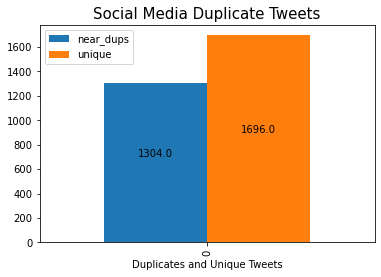

In [86]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates and Unique Tweets")
ax.set_title('Social Media Duplicate Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Health

In [92]:
df_health_sample = df_health.select('text').sample(fraction=0.01, seed=3).limit(3000)

In [ ]:
text = df_health_sample.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

#Break up text into tokens
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[rt, @pioneerpress:, lawmaker, catches, covid-19,, must, miss, his, anti-vaccine, rally\n\nhttps://t.co/udmfsqhdqk, https://t.co/ds3zkcqmwk]",0
1,"[rt, @nytimes:, breaking, news:, pfizer, said, its, pill, to, treat, covid-19, had, been, found, to, be, highly, effective, at, preventing, severe, illness, among…]",1
2,"[rt, @jburcum:, two, mn, counties, on, nytimes, list, of, top, counties, for, covid, case, growth, nationally,, and, you, don't, have, to, scroll, down, much, to, se…]",2
3,"[rt, @jburcum:, two, mn, counties, on, nytimes, list, of, top, counties, for, covid, case, growth, nationally,, and, you, don't, have, to, scroll, down, much, to, se…]",3
4,"[rt, @infectiousps:, #acip, meeting:vaccinating, just, kids, against, covid, will, prevent, case., vaccination, of, 5-11, year, olds, could, accelerate, t…]",4


In [ ]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = gov_vectorize.fit(df_tokens).transform(df_tokens)

df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[greater, demand, for, digital, solutions, in, healthcare, sector, has, been, accelerated, by, covid-19, pandemic., #pophealthit, https://t.co/eb8fpnulas]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[rt, @himss:, how, can, we, best, harness, digital, health, in, order, to, build, efficient, responses, for, future, pandemics?, #himss21me, #covid19]",1,"(1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[the, covid-19, pandemic, pushed, the, business, from, delicate, conditions, like, sexual, health, and, hair, loss, into, primary, ca…, https://t.co/ic6okutsim]",2,"(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[the, covid-19, pandemic, pushed, the, business, from, delicate, conditions, like, sexual, health, and, hair, loss, into, primary, ca…, https://t.co/ic6okutsim]",3,"(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[about, half, say, the, covid-19, pandemic, including, vaccine, appointment, coordination, and, making, the, shift, to, telehealt…, https://t.co/kwpxrocakh]",4,"(0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [ ]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
65,[Endemic means re...,"[rt, @boulware_dr...","(10071,[0,3,8,10,...","[[4045642.0], [4...."
191,[Excellent thread...,"[rt, @abecenti:, ...","(10071,[0,6,7,8,2...","[[4.1891233E7], [..."
418,[RT @FurberA: Cov...,"[eligible, new, y...","(10071,[1,3,6,7,1...","[[8.7809292E7], [..."
541,[Differential Kin...,"[rt, @drianweissm...","(10071,[0,4,23,30...","[[4.7945584E7], [..."
558,[RT @picardonheal...,"[rt, @jamesgraham...","(10071,[0,4,12,14...","[[4.7945584E7], [..."


In [ ]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [ ]:
df_dups_30 = df_dups_text
df_dups_text.limit(5).toPandas()

KeyboardInterrupt: 

In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates and Unique Tweets")
ax.set_title('Health Organization Duplicate Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### News

In [99]:
df_news_sample = df_news.select('text').sample(fraction=0.01, seed=3).limit(3000)

In [100]:
text = df_health_sample.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

#Break up text into tokens
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left')

jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [101]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  1420
Unique titles based on { 0.3 } jaccard distance:  0.3 :  1580


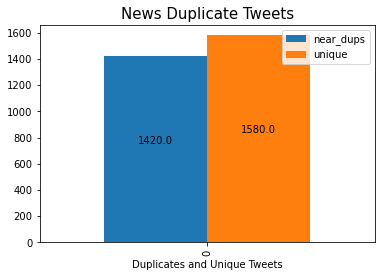

In [102]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates and Unique Tweets")
ax.set_title('News Duplicate Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Government

In [103]:
df_gov_sample = df_government.select('text').sample(fraction=0.01, seed=3).limit(3000)

In [106]:
text = df_gov_sample.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

#Break up text into tokens
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left')

jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [107]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  1489
Unique titles based on { 0.3 } jaccard distance:  0.3 :  1511


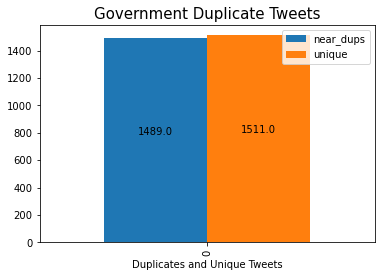

In [108]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates and Unique Tweets")
ax.set_title('Government Duplicate Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Social Media

In [109]:
df_sm_sample = df_org_social_media.select('text').sample(fraction=0.01, seed=3).limit(3000)

In [110]:
text = df_sm_sample.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

#Break up text into tokens
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left')

jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [111]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  1735
Unique titles based on { 0.3 } jaccard distance:  0.3 :  1265


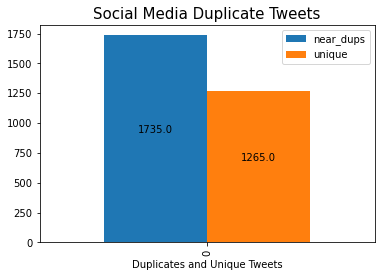

In [112]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates and Unique Tweets")
ax.set_title('Social Media Duplicate Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Health

In [113]:
df_health_sample = df_health.select('text').sample(fraction=0.01, seed=3).limit(3000)

In [114]:
text = df_health_sample.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

#Break up text into tokens
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left')

jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [115]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  1368
Unique titles based on { 0.3 } jaccard distance:  0.3 :  1632


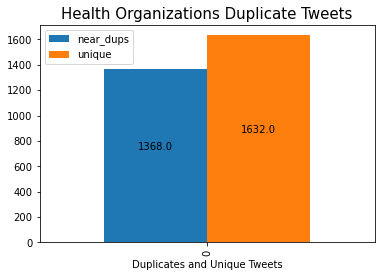

In [116]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates and Unique Tweets")
ax.set_title('Health Organizations Duplicate Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Celebrity

In [117]:
df_celebrity_sample = df_celebrity.select('text').sample(fraction=0.01, seed=3).limit(3000)

In [118]:
text = df_celebrity_sample.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

#Break up text into tokens
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left')

jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [119]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  1816
Unique titles based on { 0.3 } jaccard distance:  0.3 :  1184


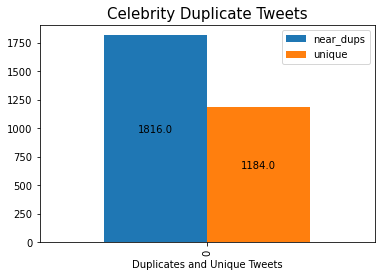

In [120]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates and Unique Tweets")
ax.set_title('Celebrity Duplicate Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Other

In [121]:
df_other_sample = df_other.select('text').sample(fraction=0.01, seed=3).limit(3000)

In [ ]:
text = df_other_sample.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

#Break up text into tokens
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left')

jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  1484
Unique titles based on { 0.3 } jaccard distance:  0.3 :  1516


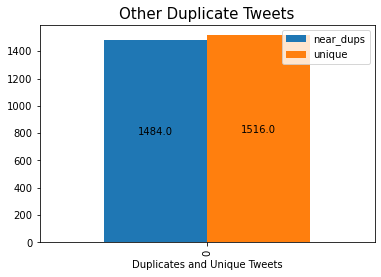

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates and Unique Tweets")
ax.set_title('Other Duplicate Tweets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 